## LIBRERÍAS

In [1]:
import numpy as np 

# procesamiento de datos
import pandas as pd 

# visualizacion de datos
import seaborn as sns
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import style
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Algoritmos ML
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV


Este es un dataset clásico de concurso de Kaggle: información sobre los pasajeros de la tragedia del Titanic. Nuestro objetivo será predecir si un pasajero sobrevivió o no al hundimiento del buque, para lo cual utilizaremos algoritmos de clasificación tipo support machine vectors desde la librería Scikit-learn. Primeramente, haremos una visualización y preprocesado de los datos para luego entrenar distintos modelos de clasificación. Finalmente, evaluaremos el rendimiento del modelo y haremos predicciones refinadas a partir de la búsqueda exhaustiva de parámetros óptimos mediante validación cruzada.

## CARGA DE DATOS

In [2]:
train_df = pd.read_csv(r'https://github.com/jfocana/SVM_MACE/blob/a2ab8ab05fac25ff41f0efad4a9b56669c0c6ba4/train.csv?raw=true')
test_df = pd.read_csv(r'https://github.com/jfocana/SVM_MACE/blob/a2ab8ab05fac25ff41f0efad4a9b56669c0c6ba4/test.csv?raw=true')
Y_true = pd.read_csv(r'https://github.com/jfocana/SVM_MACE/blob/a2ab8ab05fac25ff41f0efad4a9b56669c0c6ba4/gender_submission.csv?raw=true')
combine = [train_df, test_df]

## ESTUDIO DE LOS DATOS

### 1. DESCRIPCIÓN DE LOS DATOS

In [3]:
train_df.info()
print(' ', '_/‾\_'*8, ' ', sep='\n')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
 
_/‾\__/‾\__/‾\__/‾\__/‾\__/‾\__/‾\__/‾\_
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passe

In [4]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


- Tenemos 2 datos tipo **float**, 4 de tipo **int** y 5 tipo **object**.
- A priori, **'Survived', 'Sex', 'Embarked'** y **'Pclass'** son variables cualitativas; **'Age', 'Fare', 'SibSp'** y **'Parch'** son cuantitativas, siendo las dos primeras continuas y las dos últimas discretas. 
- **'Ticket'** y **'Cabin'** son variables mixtas. 
- La variable **'Name'** podría contener erratas y errores ya que hay varias maneras de escribir los nombres, así como incluir títulos, apodos o acortar segundos nombres de distinta manera, lo que la hace difícil de analizar.
- Además, en la tabla de entrenamiento faltan 177 datos en **'Age'**, 687 de **'Cabin'** y 2 de **'Embarked'**. Tanto los datos que faltan de **'Age'** como de **'Embarked'** se deberían poder completar.

- Por otro lado, por el carácter mixto de la variable **'Cabin'** y la poca cantidad de datos de que disponemos, parece complicado que pueda completarse y ser una variable de utilidad.
***

In [6]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- **'Survived'** es una variable categórica con valores 0 y 1 para víctimas y supervivientes, respectivamente.

- La mayoría de pasajeros (más del 75%) no viajaban con padres o hijos a bordo (**'Parch'**). 
- Algo más del 25% de pasajeros viajaban con hermanos o cónyuges a bordo (**'SibSp'**). 
- Hay gran variabilidad en las tarifas de viaje (**'Fares'**), con 3/4 partes del pasaje por debajo de los **31$** y una tarifa máxima de **512$**: posibles valores atípicos. 
- Más del 75% de los pasajeros son menores de 40 años. 
***

In [7]:
train_df.describe(include='O')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


- Los **nombres** son únicos en la tabla de datos. 
- Hay un buen número (~20%) de valores de **ticket** repetidos (¿billete familiar?).
- También de camarotes (**'Cabin'**), posiblemente por ser compartidos. 
- La variable **'Sex'** toma dos únicos valores, siendo **'male'** el ~65% de ellos. 

- La variable **'Embarked'** tiene 3 valores posibles, correspondientes cada uno al puerto en el que subió a bordo el pasajero. El puerto **'S'** es el más frecuente (644/889).
***
***

### 2. INFLUENCIA DE CADA VARIABLE EN LA SUPERVIVENCIA

    2.1. Subtablas  

A priori, parece razonable descartar la influencia de las variables **'PassengerId'** y **'Name'** en la supervivencia de los pasajeros. Agruparemos los datos según los valores de las variables no continuas y sin valores vacíos (**'Pclass'**, **'Sex'**, **'SibSp'** y **'Parch'**) para tratar de identificar correlación con la variable de estudio, **'Survived'**.

In [8]:
train_df[['Pclass', 'Survived']].groupby(['Pclass']).mean().sort_values(by='Survived', ascending=False)

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


In [9]:
train_df[['Sex', 'Survived']].groupby(['Sex']).mean().sort_values(by='Survived', ascending=False)

,Survived
Sex,
female,0.742038
male,0.188908


Tanto los pasajeros de la categoría **'Pclass'** = 1 como las **mujeres** tienen unos índices de supervivencia muy alejados de la media total. 
- Estudiar estas categorías con mayor atención.
***

In [10]:
train_df[['SibSp', 'Survived']].groupby(['SibSp']).mean().sort_values(by='Survived', ascending=False)

,Survived
SibSp,
1,0.535885
2,0.464286
0,0.345395
3,0.250000
4,0.166667
5,0.000000
8,0.000000


In [11]:
train_df[['Parch', 'Survived']].groupby(['Parch']).mean().sort_values(by='Survived', ascending=False)

,Survived
Parch,
3,0.600000
1,0.550847
2,0.500000
0,0.343658
5,0.200000
4,0.000000
6,0.000000


Tanto **'SibSp'** como **'Parch'** muestran poca correlación con la variable de estudio. 
- (¿Interesante estudiar variable resultante de unificar ambas? En otro caso, descartarlas.)

    2.2 Visualización de Datos

Observemos ahora mediante un gráfico la distribución de supervivientes en función de la edad.

c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


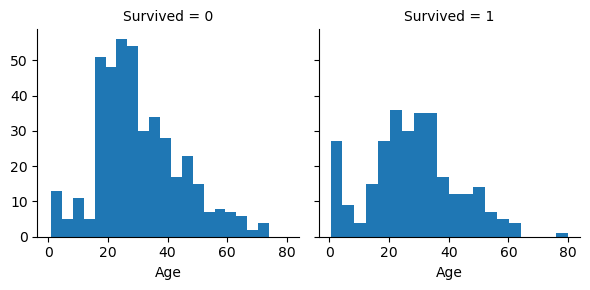

In [12]:
h_age = sns.FacetGrid(train_df, col='Survived')
h_age.map(plt.hist, 'Age', bins=20)

- Los niños menores de 4 años tienen un alto ratio de supervivencia. 

- Todos los pasajeros de mayor edad (76 a 80 años) sobreviven.
- Se cuentan las víctimas en mayor número en los pasajeros entre 16 y 32.
- La mayoría de los pasajeros pertenecen a este último grupo de edad.

Parece interesante considerar la variable **'Age'** de cara al entrenamiento del modelo, **completando** la variable y **agrupando** en categorías por franja de edad.
***

Visualicemos ahora los datos de **'Pclass'** agrupados según la variable **'Age'**.

c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


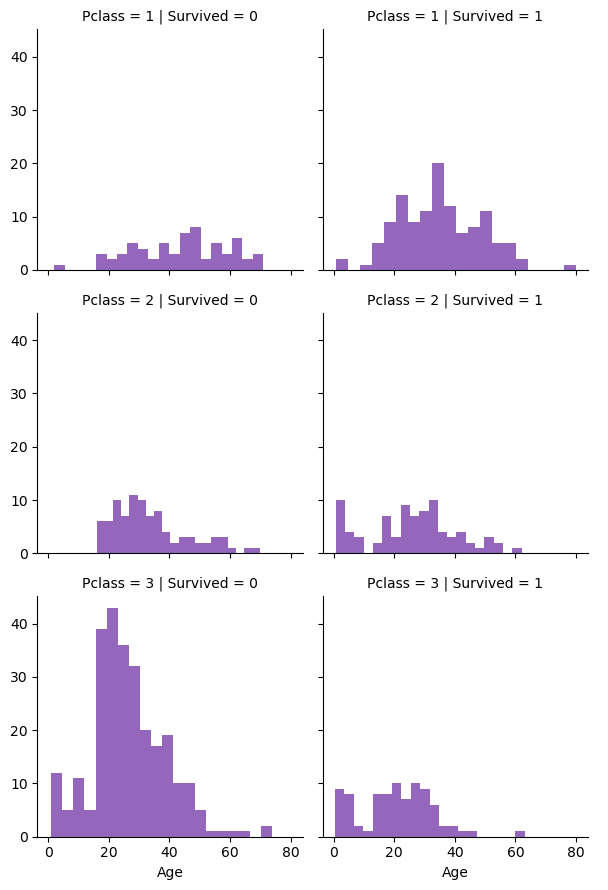

In [13]:
grid_pclass = sns.FacetGrid(train_df, col='Survived', row='Pclass')
grid_pclass.map(plt.hist, 'Age', bins=20, color= 'tab:purple')
grid_pclass.add_legend()

- **'Pclass'** = 3 es la categoría con más pasajeros y mayor proporción de víctimas. 

- La mayoría de niños en **'Pclass'** = 3 y **'Pclass'** = 2 sobreviven. 
- También la mayoría de los pasajeros en **'Pclass'** = 3 sobreviven al accidente. 
- **'Pclass'** presenta variaciones en términos de la distribución de los pasajeros por la variable **'Age'**.

Deberemos considerar la variable **'Pclass'** para el entrenamiento del modelo.

***

c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:717: UserWarning: Using the pointplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


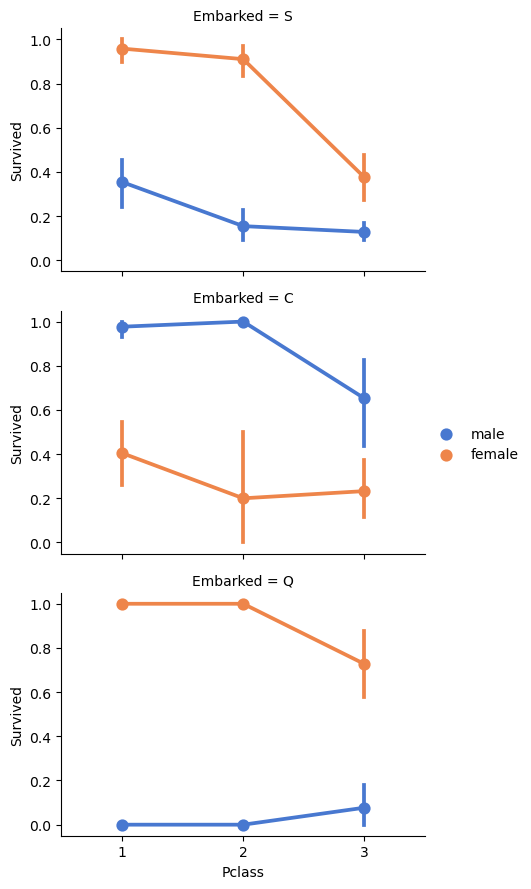

In [14]:
grid = sns.FacetGrid(train_df, row='Embarked', aspect=1.5 )
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='muted')
grid.add_legend()

In [15]:
pd.pivot_table(train_df, index=['Sex', 'Pclass'], columns='Embarked', values= 'Survived', aggfunc=len, fill_value=0)

Embarked        C   Q    S
Sex    Pclass             
female 1       43   1   48
       2        7   2   67
       3       23  33   88
male   1       42   1   79
       2       10   1   97
       3       43  39  265

- Las mujeres tienen un considerablemente mejor ratio de supervivencia que los hombres. 

- La excepción de los pasajeros del grupo **'Embarked'** = C, en la que los hombres tienen mayor ratio de supervivencia, podría ser consecuencia de la correlación entre las variables [**'Pclass'**, **'Embarked'**] y [ **'Pclass'**, **'Survived'** ] (tabla), no necesariamente indicando correlación directa entre **'Embarked'** y **'Survived'**. 

- Los hombres tienen mejor ratio de supervivencia en **'Pclass'** = 3 comparado con los hombres de **'Pclass'** = 2 y **'Pclass'** = 1.

Deberemos considerar la variable **'Sex'** para el entrenamiento del modelo, así como completar y añadir la variable **'Embarked'** para su estudio.

***

c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


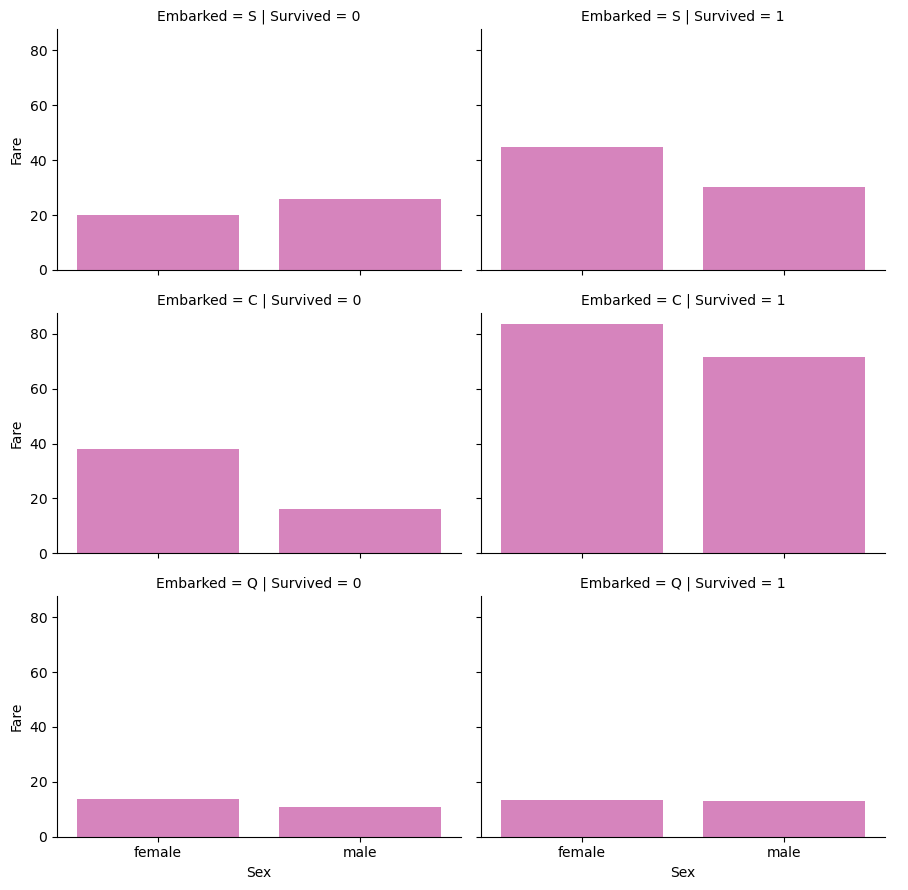

In [16]:
grid = sns.FacetGrid(train_df, row='Embarked', col='Survived', aspect=1.5)
grid.map(sns.barplot, 'Sex', 'Fare', color= 'tab:pink', errorbar=None)
grid.add_legend()

- Observamos mayor índice de supervivencia en los pasajeros con tarifas más elevadas.

- El puerto de embarque muestra correlación con las tarifas pagadas. 

Parece interesante considerar **'Fare'** como variable en el modelo, estableciendo diferentes franjas como con la variable **'Age'**.

***
***

### 3. AJUSTE DE LOS DATOS

    3.1. Descarte de Datos  

In [17]:
train_df = train_df.drop(['Ticket', 'Cabin'], axis=1)
test_df = test_df.drop(['Ticket', 'Cabin'], axis=1)
combine = [train_df, test_df]

Eliminamos los datos de las variables **'Ticket'** y **'Cabin'**. 

De la variable **'Name'** podemos extraer una nueva variable, **'Title'**, mediante la cuál trataremos de obtener información antes de descartar la utilidad de los nombres: 

In [18]:
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract('([a-zA-Z]+)\.', expand= False) # Buscamos el primer elemento del string que incluya un '.' al final y lo añadimos a una nueva columna

pd.crosstab(train_df['Title'], train_df['Sex']) 

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


Algunos de estos títulos son demasiado específicos e infrecuentes para ser analizados, mientras que otros son equivalentes entre sí. Combiene agrupar los primeros en un grupo aparte y normalizar los demás:

In [19]:
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    

Visualicemos si el índice de supervivencia podría tener relación con esta nueva variable: 

In [20]:
train_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.347826


Con estas diferencias en los ratios, podría ser interesante estudiar la nueva variable, para lo cual la transformaremos en una variable ordinal: 

In [21]:
Title_map = {"Master": 1, "Miss": 2, "Mrs": 3, "Mr": 4, "Rare": 5}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(Title_map)
    dataset['Title'] = dataset['Title'].fillna(0)


Ahora podemos definitivamente descartar la variable **'Name'**, así cómo **'PassengerId'**.

In [22]:
train_df = train_df.drop(['Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
combine = [train_df, test_df]

    3.2. Tratamiento de Variables  

Empezamos por convertir la variable **'Sex'** en una variable ordinal: 

In [23]:
for dataset in combine:
    dataset['Sex'] = dataset['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

***
Necesitamos ahora completar la variable **'Age'** antes de proceder a transformarla. Para ello hay dos enfoques diferentes: 

- Utilizar un vector de valores aleatorios ajustados a la media y desviación típica de la distribución de la variable 


In [24]:
# age_mean = est_df.mean()
# age_std = est_df.std()
# age_est = rnd.uniform(age_mean - age_std, age_mean + age_std)

- Completar a partir de otras variables con las que **'Age'** esté correlacionada. 

En general preferimos descartar la primera opción para entrenar modelos de Machine Learning, ya que introducen un factor de aleatoriedad en el entrenamiento que no es deseado, haciendo que diferentes iteraciones del proceso den lugar a resultados que pueden variar, y procedemos al segundo método.

Hemos podido advertir previamente correlación entre **'Age'** y **'Pclass'**, y podría ser razonable suponerla también con  **'Sex'**: 

c:\Users\paco_\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


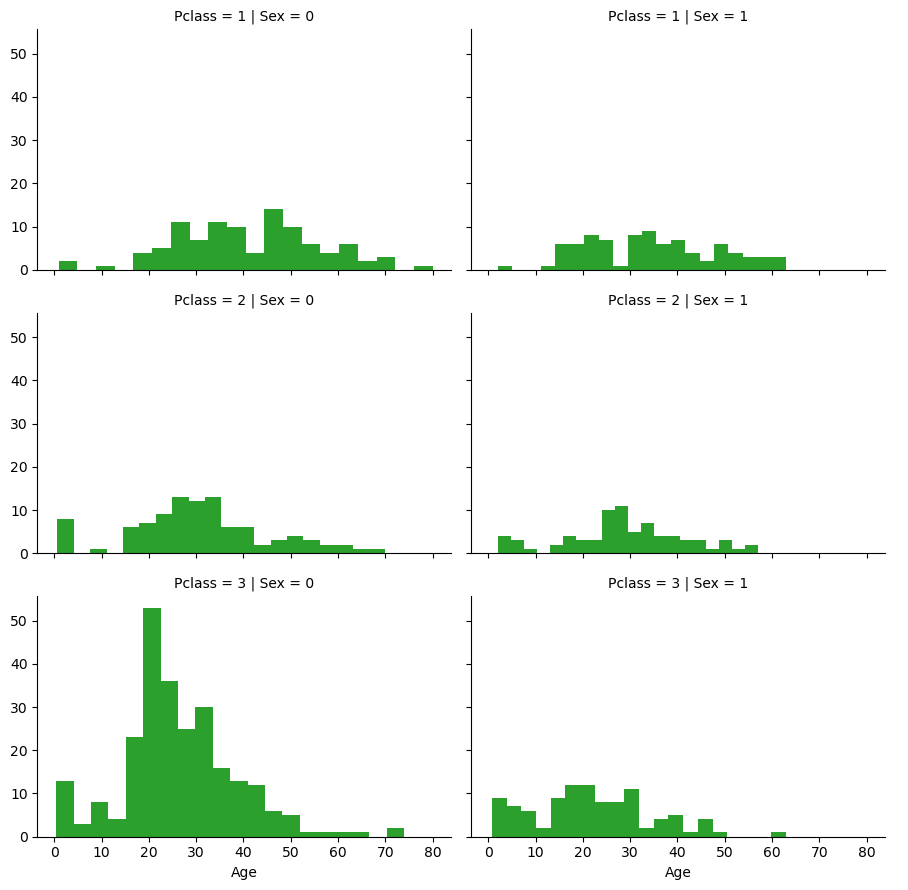

In [25]:
grid = sns.FacetGrid(train_df, row='Pclass', col='Sex', aspect=1.5)
grid.map(plt.hist, 'Age', color= 'tab:green', bins=20)
grid.add_legend()

Preparamos un vector vacío con valores de edad para cada **'Pclass'** en función de **'Sex'**:

In [26]:
est_age = np.zeros((2,3))
est_age

array([[0., 0., 0.],
       [0., 0., 0.]])

In [27]:
for dataset in combine:
    for i in range(0, 2):
        for j in range(0, 3):
            est_df = dataset[(dataset['Sex'] == i) & (dataset['Pclass'] == j+1)]['Age'].dropna()

           
            age_est = est_df.median()

            # Convertimos el float de edad a la edad más cercana (+/- 0.5)
            est_age[i,j] = int( age_est/0.5 + 0.5 ) * 0.5

est_age
            

array([[42., 28., 24.],
       [41., 24., 22.]])

Completamos la tabla ahora con el vector de valores que hemos obtenido 

In [28]:
for dataset in combine:    
    for i in range(0, 2):
        for j in range(0, 3):
            dataset.loc[ (dataset.Age.isnull()) & (dataset.Sex == i) & (dataset.Pclass == j+1),\
                    'Age'] = est_age[i,j]

    dataset['Age'] = dataset['Age'].astype(int)

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
0,0,3,0,22,1,0,7.2500,S,4
1,1,1,1,38,1,0,71.2833,C,3
2,1,3,1,26,0,0,7.9250,S,2
3,1,1,1,35,1,0,53.1000,S,3
4,0,3,0,35,0,0,8.0500,S,4
...,...,...,...,...,...,...,...,...,...
886,0,2,0,27,0,0,13.0000,S,5
887,1,1,1,19,0,0,30.0000,S,2
888,0,3,1,22,1,2,23.4500,S,2
889,1,1,0,26,0,0,30.0000,C,4


Ahora podemos empezar a crear los (5) intervalos de edad y estudiar la correlación que tienen con la variable objetivo. 

In [29]:
train_df['AgeI'] = pd.cut(train_df['Age'], 5)
train_df[['AgeI', 'Survived']].groupby(['AgeI'], as_index=False).mean().sort_values(by='AgeI', ascending=True)

,AgeI,Survived
0,"(-0.08, 16.0]",0.550000
1,"(16.0, 32.0]",0.337374
2,"(32.0, 48.0]",0.412037
3,"(48.0, 64.0]",0.434783
4,"(64.0, 80.0]",0.090909


Utilizando estos intervalos, reemplazamos los valores de edad por los ordinales correspondientes a cada uno: 

In [30]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4

train_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,AgeI
0,0,3,0,1,1,0,7.2500,S,4,"(16.0, 32.0]"
1,1,1,1,2,1,0,71.2833,C,3,"(32.0, 48.0]"
2,1,3,1,1,0,0,7.9250,S,2,"(16.0, 32.0]"
3,1,1,1,2,1,0,53.1000,S,3,"(32.0, 48.0]"
4,0,3,0,2,0,0,8.0500,S,4,"(32.0, 48.0]"
...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,1,0,0,13.0000,S,5,"(16.0, 32.0]"
887,1,1,1,1,0,0,30.0000,S,2,"(16.0, 32.0]"
888,0,3,1,1,1,2,23.4500,S,2,"(16.0, 32.0]"
889,1,1,0,1,0,0,30.0000,C,4,"(16.0, 32.0]"


Ya podemos desechar la variable auxiliar **'AgeI'**

In [31]:
train_df = train_df.drop(['AgeI'], axis=1)
combine = [train_df, test_df]

***
Necesitamos completar también los valores que faltan de **'Embarked'** y **'Fare'**. Puesto que solo faltan 2 y 1 valores, respectivamente, en lugar de lo anterior simplemente completaremos con el valor modal para la variable categórica y el valor mediano para la variable numérica.

In [32]:
m_port = train_df.Embarked.dropna().mode()

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].fillna(m_port[0])

Y una vez completa, reemplazamos los valores de la variable por ordinales.

In [33]:
ports_map= {'S': 0, 'C': 1, 'Q': 2}

for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( ports_map ).astype(int)

In [34]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

Hecho esto, podemos agrupar también las tarifas por intervalos, como hicimos con la edad, para asignar a cada dato original de **'Fare'** un valor categórico en función de a cuál pertenezca:

In [35]:
train_df['FareI'] = pd.qcut(train_df['Fare'], 4)
train_df[['FareI', 'Survived']].groupby(['FareI'], as_index=False).mean().sort_values(by='FareI', ascending=True)

,FareI,Survived
0,"(-0.001, 7.91]",0.197309
1,"(7.91, 14.454]",0.303571
2,"(14.454, 31.0]",0.454955
3,"(31.0, 512.329]",0.581081


In [36]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

    
train_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,FareI
0,0,3,0,1,1,0,0,0,4,"(-0.001, 7.91]"
1,1,1,1,2,1,0,3,1,3,"(31.0, 512.329]"
2,1,3,1,1,0,0,1,0,2,"(7.91, 14.454]"
3,1,1,1,2,1,0,3,0,3,"(31.0, 512.329]"
4,0,3,0,2,0,0,1,0,4,"(7.91, 14.454]"


Podemos desechar la variable auxiliar **'FareI'**.

In [37]:
train_df = train_df.drop(['FareI'], axis=1)

combine = [train_df, test_df]

***

Combinamos las variables **'SibSp'** + **'Parch'** en una nueva variable, **'Relatives'**, que cuenta el número de familiares que forman parte del pasaje para cada sujeto.


In [38]:
for dataset in combine:
    dataset['Relatives'] = dataset['SibSp'] + dataset['Parch']

train_df[['Relatives', 'Survived']].groupby(['Relatives']).mean()

,Survived
Relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Como hay demasiadas subcategorías, trataremos agruparlas en una nueva variable, **'RelAboard'**, de manera que asigna a los pasajeros que viajan solos el valor **0** y **1** a los que viajan con algún familiar a bordo.

In [39]:
for dataset in combine:
    dataset['RelAboard'] = 1
    dataset.loc[dataset['Relatives'] == 0, 'RelAboard'] = 0

train_df[['RelAboard', 'Survived']].groupby(['RelAboard'], as_index=False).mean()

,RelAboard,Survived
0,0,0.303538
1,1,0.505650


Esta nueva variable parece más razonable a la hora de ser estudiada y se mantiene en nuestro modelo, en detrimento de las variables **'Parch', 'SibSp'** y **'Relatives'**.

In [40]:
train_df = train_df.drop(['Parch', 'SibSp', 'Relatives'], axis=1)
test_df = test_df.drop(['Parch', 'SibSp', 'Relatives'], axis=1)
combine = [train_df, test_df]

In [41]:
test_df.head(10)

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Title,RelAboard
0,892,3,0,2,0,2,4,0
1,893,3,1,2,0,0,3,1
2,894,2,0,3,1,2,4,0
3,895,3,0,1,1,0,4,0
4,896,3,1,1,1,0,3,1
5,897,3,0,0,1,0,4,0
6,898,3,1,1,0,2,2,0
7,899,2,0,1,2,0,4,1
8,900,3,1,1,0,1,3,0
9,901,3,0,1,2,0,4,1


***
***

## MODELOS Y PREDICCIONES

    Normalización y declaración de los datos de entrenamiento

In [42]:
scaler = StandardScaler()
scaler.fit(train_df.drop('Survived', axis=1).copy())

X_train = scaler.transform(train_df.drop('Survived', axis=1).copy())
Y_train = train_df['Survived']
Y_true = Y_true.drop('PassengerId', axis=1).copy()
X_test  = scaler.transform(test_df.drop('PassengerId', axis=1).copy())

X_train.shape, Y_train.shape, X_test.shape, Y_true.shape

((891, 7), (891,), (418, 7), (418, 1))

### Logistic Regression

In [43]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)

Este modelo nos permite confirmar o descartar las hipótesis de correlación que hemos planteado a lo largo del estudio.

In [44]:
coeff_df = pd.DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Feature']
coeff_df["Correlation"] = pd.Series(logreg.coef_[0])

coeff_df.sort_values(by='Correlation', ascending=False)

,Feature,Correlation
1,Sex,0.930821
4,Embarked,0.166449
6,RelAboard,-0.030329
3,Fare,-0.097433
2,Age,-0.266551
5,Title,-0.531961
0,Pclass,-1.102329


Las variables más fuertemente correlacionadas con la supervivencia son el sexo e, inversamente, **Pclass**. Parecen estar débilmente correlacionadas tanto el viajar acompañado o no como las tarifas de embarque.

In [45]:
scaler = StandardScaler()
scaler.fit(train_df.drop(['Survived', 'RelAboard', 'Fare'], axis=1).copy())

X_train = scaler.transform(train_df.drop(['Survived', 'RelAboard', 'Fare'], axis=1).copy())
Y_train = train_df['Survived']
X_test  = scaler.transform(test_df.drop(['PassengerId', 'RelAboard', 'Fare'], axis=1).copy())
X_train.shape, Y_train.shape, X_test.shape, Y_true.shape

((891, 5), (891,), (418, 5), (418, 1))

Hemos eliminado las variables con baja correlación.
***
Utilizaremos dos métricas para evaluar el modelo: la precisión y el f1-score. 
La precisión es la proporción de verdaderos positivos sobre el total de positivos predichos, mientras que el f1-score es la media armónica entre la precisión y el recall (la proporción de verdaderos positivos sobre el total de positivos reales).


### 1. SVC Lineal Primal

In [46]:
linear_svc = LinearSVC(dual=False)
linear_svc.fit(X_train, Y_train)
acc_lsvc = round(linear_svc.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = linear_svc.predict(X_test)
f1_linear_svc = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_lsvc, f1_linear_svc)

(97.8469, 97.0297)

### 2. SVC Lineal Dual

In [47]:
ldual_svc = LinearSVC(dual=True)
ldual_svc.fit(X_train, Y_train)
acc_ldual_svc = round(ldual_svc.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = ldual_svc.predict(X_test)
f1_ldual_svc = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_ldual_svc, f1_ldual_svc)

(97.8469, 97.0297)

### 3. SVC RBF


In [48]:
svc_rbf = SVC()
svc_rbf.fit(X_train, Y_train)
acc_svc_rbf = round(svc_rbf.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_rbf.predict(X_test)
f1_svc_rbf = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_rbf, f1_svc_rbf)

(87.799, 81.0409)

### 4. SVC Polinomial

In [49]:
svc_poly = SVC(kernel= "poly")
svc_poly.fit(X_train, Y_train)
acc_svc_poly = round(svc_poly.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_poly.predict(X_test)
f1_svc_poly = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_poly, f1_svc_poly)

(85.6459, 77.2727)

### 5. SVC Sigmoidal

In [50]:
svc_sig = SVC(kernel= "sigmoid")
svc_sig.fit(X_train, Y_train)
acc_svc_sig = round(svc_sig.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_sig.predict(X_test)
f1_svc_sig = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_sig, f1_svc_sig)

(78.7081, 70.8197)

Por las métricas que obtenemos para estos modelos, parece que nuestra base de datos tiene un comportamiento lineal en cuanto a la clasificación supervivientes-víctimas. 


***

Para refinar los modelos y mejorar el resultado de estos, el procedimiento recomendable a seguir es hacer una búsqueda exhaustiva de hiperparámetros (un GridSearch) que nos ayude a optimizar modelo, a través de una posterior Cross Validation.

#### Grid Search SVC Lineal Primal 

In [51]:
svc_grid = {'C': [1, 10, 1000, 100000, 10**10], 'penalty': ['l1', 'l2']}
linear_svc = LinearSVC(dual=False)
clf = GridSearchCV(linear_svc, svc_grid, cv=5)
clf.fit(X_train, Y_train)
df = pd.concat([pd.DataFrame(clf.cv_results_['params']),
                pd.DataFrame(clf.cv_results_['mean_test_score'],
                              columns=['Accuracy'])],
               axis=1)
df.sort_values(by='Accuracy', ascending=False)

,C,penalty,Accuracy
0,1,l1,0.799084
1,1,l2,0.799084
2,10,l1,0.799084
3,10,l2,0.799084
4,1000,l1,0.799084
5,1000,l2,0.799084
6,100000,l1,0.799084
7,100000,l2,0.799084
8,10000000000,l1,0.799084
9,10000000000,l2,0.799084


#### Grid Search SVC Lineal Dual 

In [52]:
svc_grid = {'C':  [1, 10, 1000], 'loss': ['hinge', 'squared_hinge'] }
linear_svc = LinearSVC(dual= True, max_iter= 10000)
clf = GridSearchCV(linear_svc, svc_grid, cv=5)
clf.fit(X_train, Y_train)
df = pd.concat([pd.DataFrame(clf.cv_results_['params']),
                pd.DataFrame(clf.cv_results_['mean_test_score'],
                              columns=['Accuracy'])],
               axis=1)
df.sort_values(by='Accuracy', ascending=False)

c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\paco_\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number 

,C,loss,Accuracy
1,1,squared_hinge,0.799084
3,10,squared_hinge,0.799084
0,1,hinge,0.786737
2,10,hinge,0.786737
4,1000,hinge,0.786737
5,1000,squared_hinge,0.766587


#### Grid Search SVC RBF 

In [53]:
svc_grid = {'C': [1, 10, 1000, 100000, 10**10], 'gamma': ['scale', 'auto']}
svc = SVC(kernel= 'rbf')
clf = GridSearchCV(svc, svc_grid, cv=5)
clf.fit(X_train, Y_train)
df = pd.concat([pd.DataFrame(clf.cv_results_['params']),
                pd.DataFrame(clf.cv_results_['mean_test_score'],
                              columns=['Accuracy'])],
               axis=1)
df.sort_values(by='Accuracy', ascending=False)

,C,gamma,Accuracy
4,1000,scale,0.826050
5,1000,auto,0.826050
6,100000,scale,0.826050
7,100000,auto,0.826050
8,10000000000,scale,0.826050
9,10000000000,auto,0.826050
0,1,scale,0.823809
1,1,auto,0.823809
2,10,scale,0.823803
3,10,auto,0.823803


#### Grid Search SVC Polinomial

In [54]:
svc_grid = {'C': [1, 10, 100, 1000], 'degree': [2,3,4], 'gamma': ['scale', 'auto']}
svc = SVC(kernel= 'poly')
clf = GridSearchCV(svc, svc_grid, cv=5)
clf.fit(X_train, Y_train)
df = pd.concat([pd.DataFrame(clf.cv_results_['params']),
                pd.DataFrame(clf.cv_results_['mean_test_score'],
                              columns=['Accuracy'])],
               axis=1)
df.sort_values(by='Accuracy', ascending=False)

,C,degree,gamma,Accuracy
9,10,3,auto,0.823815
8,10,3,scale,0.823815
2,1,3,scale,0.822685
3,1,3,auto,0.822685
20,1000,3,scale,0.821568
21,1000,3,auto,0.821568
15,100,3,auto,0.820444
14,100,3,scale,0.820444
4,1,4,scale,0.815944
16,100,4,scale,0.813722


#### Grid Search SVC Sigmoidal

In [55]:
svc_grid = {'C': [1, 10, 1000, 100000, 10**10], 'gamma': ['scale', 'auto']}
svc = SVC(kernel= 'sigmoid')
clf = GridSearchCV(svc, svc_grid, cv=5)
clf.fit(X_train, Y_train)
df = pd.concat([pd.DataFrame(clf.cv_results_['params']),
                pd.DataFrame(clf.cv_results_['mean_test_score'],
                              columns=['Accuracy'])],
               axis=1)
df.sort_values(by='Accuracy', ascending=False)

,C,gamma,Accuracy
0,1,scale,0.694740
1,1,auto,0.694740
5,1000,auto,0.680133
7,100000,auto,0.680133
4,1000,scale,0.679016
3,10,auto,0.674515
2,10,scale,0.673392
6,100000,scale,0.672274
9,10000000000,auto,0.667786
8,10000000000,scale,0.658791


Utilizando los parámetros podemos obtener una versión optimizada de cada uno de los modelos, y así obtener una predicción más ajustada.

## Predicciones refinadas

### Mejor SVC Lineal Primal

In [56]:
linear_svc = LinearSVC(dual=False, C=1, penalty='l2')
linear_svc.fit(X_train, Y_train)
acc_lsvc = round(linear_svc.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = linear_svc.predict(X_test)
f1_linear_svc = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_lsvc, f1_linear_svc)

(97.8469, 97.0297)

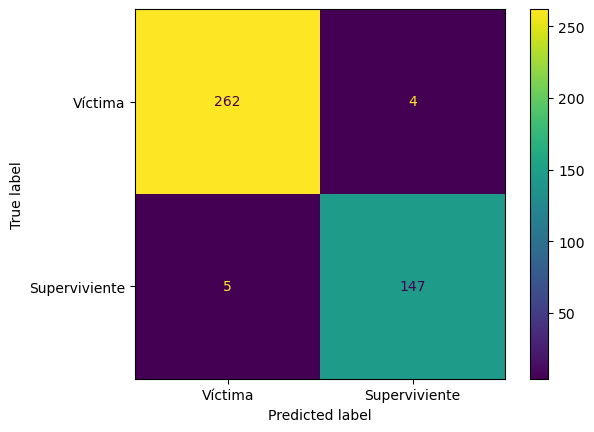

In [57]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_true, Y_pred), display_labels = ['Víctima', 'Superviviente'])

cm_display.plot()
plt.show()

### Mejor SVC Lineal Dual

In [58]:
ldual_svc = LinearSVC(dual=True, C=1, loss='squared_hinge')
ldual_svc.fit(X_train, Y_train)
acc_ldual_svc = round(ldual_svc.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = ldual_svc.predict(X_test)
f1_ldual_svc = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_ldual_svc, f1_ldual_svc)

(97.8469, 97.0297)

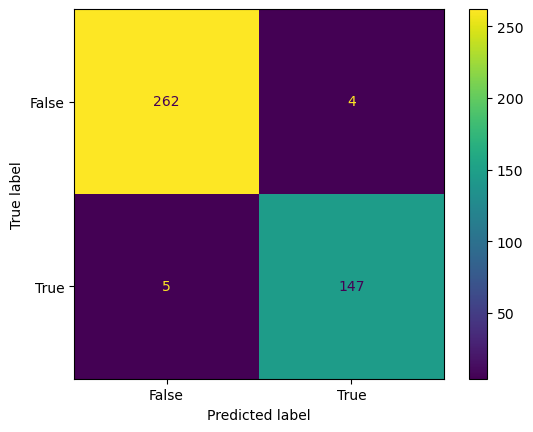

In [59]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_true, Y_pred), display_labels = [False, True])

cm_display.plot()
plt.show()

### Mejor SVC RBF

In [60]:
svc_rbf = SVC(C=1000, gamma='scale')
svc_rbf.fit(X_train, Y_train)
acc_svc_rbf = round(svc_rbf.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_rbf.predict(X_test)
f1_svc_rbf = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_rbf, f1_svc_rbf)

(89.2344, 83.871)

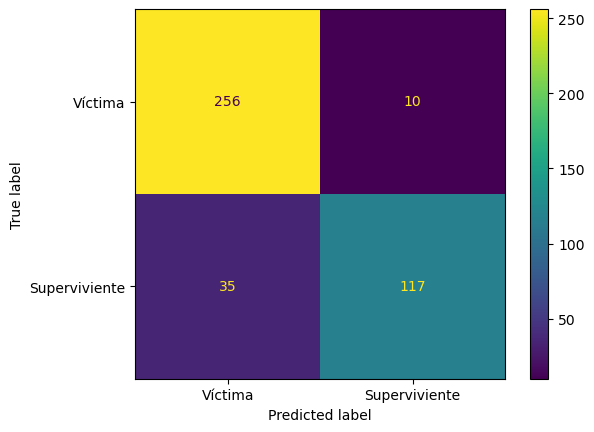

In [61]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_true, Y_pred), display_labels = ['Víctima', 'Superviviente'])

cm_display.plot()
plt.show()

### Mejor SVC Polinomial

In [62]:
svc_poly = SVC(kernel= "poly", C=10, degree=3, gamma='auto')
svc_poly.fit(X_train, Y_train)
acc_svc_poly = round(svc_poly.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_poly.predict(X_test)
f1_svc_poly = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_poly, f1_svc_poly)

(86.6029, 79.1045)

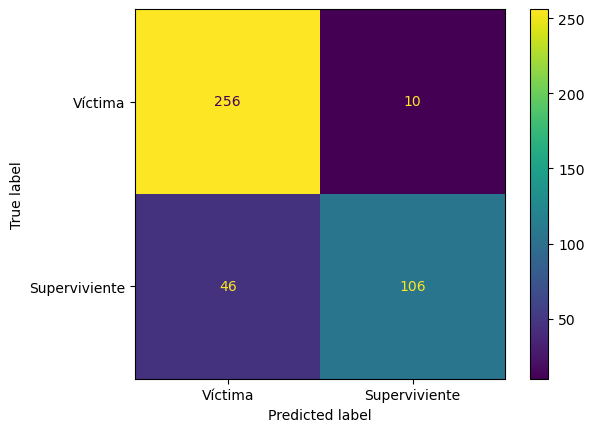

In [63]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_true, Y_pred), display_labels = ['Víctima', 'Superviviente'])

cm_display.plot()
plt.show()

### Mejor SVC Sigmoidal

In [64]:
svc_sig = SVC(kernel= "sigmoid", C=1, gamma='scale')
svc_sig.fit(X_train, Y_train)
acc_svc_sig = round(svc_sig.score(X_test, Y_true) * 100, 4)
# Predicciones
Y_pred = svc_sig.predict(X_test)
f1_svc_sig = round(f1_score(Y_true, Y_pred) * 100, 4)
(acc_svc_sig, f1_svc_sig)

(78.7081, 70.8197)

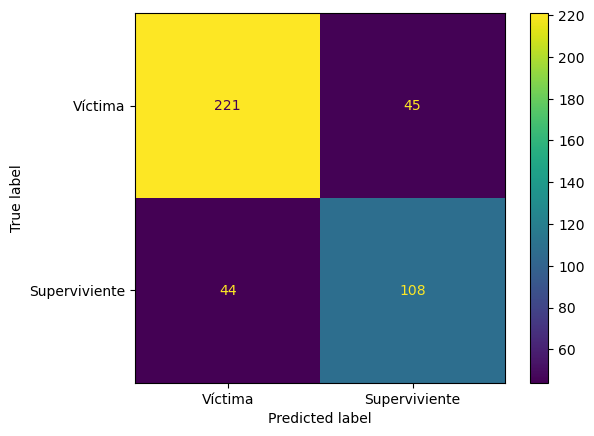

In [65]:
cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(Y_true, Y_pred), display_labels = ['Víctima', 'Superviviente'])

cm_display.plot()
plt.show()

De lo que concluimos que el modelo que mejor se ajusta a los datos es el SVC Lineal, con un f1-score del 97'02% y una precisión de 97'84%.